In [1]:
%cd ..

/volatile/home/Zaccharie/workspace/understanding-unets


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

from learning_wavelets.data import im_generators, ConcatenateGenerators
from learning_wavelets.evaluate import Metrics
from learning_wavelets.wavelet_denoising import wavelet_denoising_pysap


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.17.4    installed
matplotlib     : >=3.0.0   - required | 3.1.0     installed
astropy        : >=3.0.0   - required | 3.1.2     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [3]:
np.random.seed(0)

In [4]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In [5]:
grey = True
n_channels = 3
if grey:
    n_channels = 1
noise_std = 30
im_gen_train, im_gen_val, im_gen_test, size, n_samples_train = im_generators(
    'bsd68', 
    batch_size=1, 
    validation_split=0.1, 
    no_augment=True, 
    noise_std=noise_std,
    grey=grey
)    
im_bsd68 = ConcatenateGenerators(im_gen_train, im_gen_val, im_gen_test)

In [6]:
def enumerate_seq_noisy(seq, name):
    return (np.squeeze(seq[i][0]) for i in tqdm_notebook(range(len(seq)), desc=f'Val files for {name}'))

def enumerate_seq_gt(seq):
    return (np.squeeze(seq[i][1]) for i in range(len(seq)))

def enumerate_seq(seq, name):
    return (seq[i] for i in tqdm_notebook(range(len(seq)), desc=f'Val files for {name}'))

def metrics_original():
    metrics = Metrics()
    pred_and_gt = [
        (images_noisy, images_gt)
        for images_noisy, images_gt in enumerate_seq(im_bsd68, 'Original noisy image')
    ]    
    for im_recos, images in tqdm_notebook(pred_and_gt, desc='Original noisy image'):
        metrics.push(images, im_recos)
    return metrics

def metrics_wavelets():
    metrics = Metrics()
    pred = wavelet_denoising_pysap(
        enumerate_seq_noisy(im_bsd68, 'Wavelet denoising'),
        noise_std=noise_std/255,
        wavelet_id='24', 
        n_scales=5, 
        soft_thresh=False, 
        n_sigma=3,
    )
    gt = enumerate_seq_gt(im_bsd68)
    for im_recos, images in tqdm_notebook(zip(pred, gt), desc='Stats for wavelet denoising'):
        metrics.push(images[..., None], im_recos[..., None])
    return metrics

In [7]:
%%time
metrics = []    
metrics.append(('original', metrics_original()))
metrics.append(('wavelets', metrics_wavelets()))


CPU times: user 36min 15s, sys: 9.65 s, total: 36min 24s
Wall time: 1min 37s


In [8]:
metrics

[('original', PSNR = 18.32 +/- 0.9447 SSIM = 0.3337 +/- 0.2104),
 ('wavelets', PSNR = 26.25 +/- 4.441 SSIM = 0.6984 +/- 0.1776)]

In [9]:
image_noisy, image = im_bsd68[0]

In [10]:
denoised_images = wavelet_denoising_pysap(
    [np.squeeze(image_noisy)],
    noise_std=noise_std/255,
    wavelet_id='24', 
    n_scales=5, 
    soft_thresh=False, 
    n_sigma=5,
)

<IPython.core.display.Javascript object>


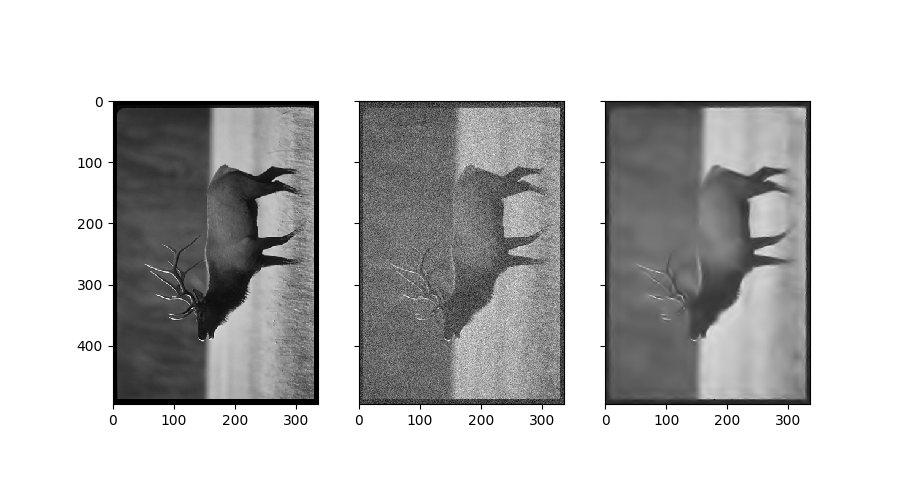

In [11]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
axs[0].imshow(np.squeeze(image))
axs[1].imshow(np.squeeze(image_noisy))
axs[2].imshow(denoised_images[0])